# NLDisco Tutorial

This tutorial introduces **NLDisco** (**N**eural **L**atent **Disco**very pipeline).

**Goal:** Discover interpretable latents (i.e., *features*) in high-dimensional neural data.

**Terminology:**

- *Neural / Neuronal:* Refers to biological neurons. Distinguished from *model neurons* (see below).
- *Units:* Putative biological neurons -- the output from spikesorting extracellular electrophysiological data.
- *Model neurons:* Neurons in a neural network model (aka *latents*)
- *Features:* Interpretable latents (latent dimensions that align with meaningful behavioral or environmental variables)

![](./tutorial_figures/sae.svg)

Motivated by successful applications of sparse dictionary learning in AI mechanistic interpretability, NLDisco trains overcomplete sparse encoder-decoder (SED) models to reconstruct neural activity based on a set of sparsely active dictionary elements (i.e. latents), implemented as hidden layer neurons. In the figure above, this is illustrated as reconstructing target neural activity $z$ from input neural activity $y$ via $d$. Sparsity in the latent space encourages a monosemantic dictionary, where each hidden layer neuron corresponds to a single neural representation that can be judged for interpretability, making SEDs a simple but effective tool for neural latent discovery. 

These SEDs can be configured as autoencoders (SAEs) if the target for $z$ is $y$ (e.g. M1 activity based on M1 activity), or as transcoders if the target for $z$ is dependent on or related to $y$ (e.g. M1 activity based on M2 activity, or M1 activity on day 2 based on M1 activity on day 1). In this tutorial, we will work exclusively with SAEs.

We consider a latent’s interpretability in two key aspects:

1. its correspondence to a specific external variable – a "natural" behavioral or environmental feature

2. its explicit composition from contributing neural activity

**NLDisco pipeline:**

1. Load and prepare data
    - Neural data in the form of $[time \times space]$, and in this tutorial specifically as binned spike counts of $[examples \times units]$

2. Train models 
    - Train models to reconstruct the neural data (in this tutorial, from the Churchland MC Maze dataset)
    - Validate the quality of the models by looking at the sparsity of the latent activations and reconstruction quality of the neural data

3. Save or load the model activations

4. Find features
    - Automatically generate promising mappings between model neurons (latents) and behavioral and/or environmental data
    - Find meaningful features and their top contributing units using an interactive dashboard
        - The mappings are a starting point to guide the search
        - A user can also choose to look through model neurons manually

___

## Setup

**Environment setup:**

Prerequisite: an installed version of [pixi](https://pixi.sh/latest/)

Steps:
1. In the repo's root directory, run `pixi install --manifest-path ./pyproject.toml`. This will create an environment in a newly created `.pixi/envs` folder.
2. Run `pixi run postinstall`

**Data download:**

Once your environment is set up, use it as a kernel for this notebook and run the cell below to automatically download and preprocess the [churchland_shenoy_neural_2012 dataset](https://brainsets.readthedocs.io/en/latest/glossary/brainsets.html#churchland-shenoy-neural-2012) (also known as MC_Maze). With the data downloaded, you can jump straight into the tutorial!

In [ ]:
from nldisco import mc_maze

# Directories for raw and processed data
raw_data_dir = "../data/raw"
processed_data_dir = "../data/processed"

# Subject name and number of their sessions to download
# Max 4 for jenkins and 3 for nitschke
# Be aware that these files are large (~2-7GB each)
subject_name = "nitschke"  # "jenkins" or "nitschke"
num_files = 1  

mc_maze.download_and_preprocess(raw_data_dir, processed_data_dir, subject_name, num_files=num_files)

# To load all the data, use:
# mc_maze.download_and_preprocess(raw_data_dir, processed_data_dir, "jenkins", num_files=4)
# mc_maze.download_and_preprocess(raw_data_dir, processed_data_dir, "nitschke", num_files=3)

___

## Tutorial start!

In the churchland_shenoy_neural_2012 dataset, the subjects are performing a center-out reaching task on a variety of different maze configurations. Each maze configuration comes in 3 versions:
- 1 target and no barriers.
- 1 target with barriers.
- 3 targets, with barriers. But 2 of the targets are distractors and unaccessible given the barrier configuration.

So maze conditions 1, 2, 3 are related; as are maze conditions 4, 5, 6; and so on.
Neural activity was recorded from the dorsal premotor (PMd) and primary motor (M1) cortices. A variety of other data (monkey hand position, velocity and acceleration, gaze position...) is also provided.

In [1]:
"""Set notebook settings."""

%load_ext autoreload
%autoreload 2

In [2]:
"""Import packages."""

# Standard library
from datetime import datetime
from pathlib import Path

# IPython/Jupyter
from IPython.display import display

# Third-party
import numpy as np
import pandas as pd
import seaborn as sns
import torch as t
from einops import asnumpy, reduce
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import r2_score
from tqdm.notebook import tqdm

# Local project modules
from nldisco import train as nt
from nldisco import mc_maze
from nldisco.train_val_split import train_val_split_by_proportion, train_val_split_by_session
from nldisco import pipeline

# 1. Load and prepare data

## Load and prepare spike data

In [3]:
"""Load session data and bin spikes."""

data_path = Path(r"../data/processed")
subject_name = "nitschke"  # "jenkins" or "nitschke"
sessions = mc_maze.load_sessions(data_path, subject_name)

bin_size = 0.05  # in seconds
spikes_df = mc_maze.bin_spike_data(sessions, bin_size)  # this can take several minutes

display(spikes_df)


Loading file 1/1: nitschke_20090812_center_out_reaching.h5
Session ID: nitschke_20090812_center_out_reaching
Session subject id: nitschke
Session subject sex: MALE
Session subject species: MACACA_MULATTA
Session recording date: 2009-08-12 00:00:00
Original number of trials: 3038
Cleaning data...
Final number of trials after cleaning: 1906

Successfully loaded and cleaned 1 sessions for subject nitschke

List of maze conditions present in each session:
Session nitschke_20090812_center_out_reaching: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]


,0,1,2,3,4,5,6,7,8,9,...,181,182,183,184,185,186,187,188,189,190
timestamp,,,,,,,,,,,,,,,,,,,,,
1.250035e+09,1,2,0,1,2,3,0,1,1,0,...,0,1,2,2,1,0,1,0,1,0
1.250035e+09,4,0,1,2,3,2,0,2,2,0,...,3,2,1,1,2,2,2,4,1,0
1.250035e+09,1,6,2,2,2,1,3,3,1,2,...,2,2,3,2,3,2,1,1,4,3
1.250035e+09,0,2,1,1,2,2,0,1,1,0,...,1,0,3,3,4,2,1,0,0,0
1.250035e+09,1,2,4,1,4,0,0,0,1,1,...,0,3,2,1,1,2,2,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.250056e+09,0,0,3,0,3,2,1,2,5,2,...,1,3,0,2,0,5,0,1,1,2
1.250056e+09,0,1,3,0,2,2,3,5,4,3,...,0,1,0,1,1,2,2,1,0,2
1.250056e+09,0,1,1,1,2,4,1,2,2,1,...,0,2,0,2,1,3,3,0,2,1


Firing rates distribution:


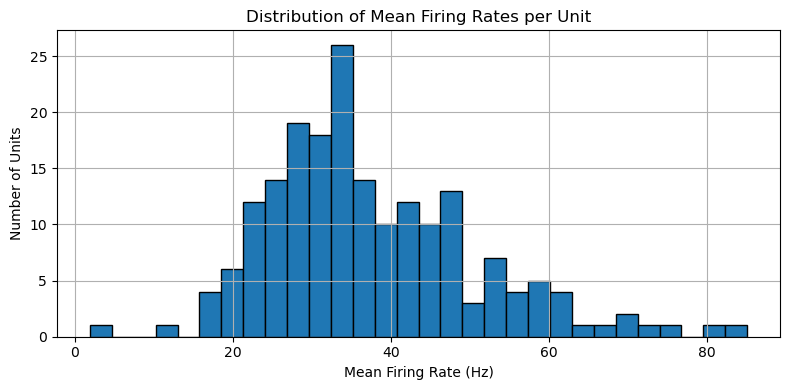

Mean: 37.51 Hz
Range: 1.94–85.06 Hz


Spike count distribution and sparsity stats:


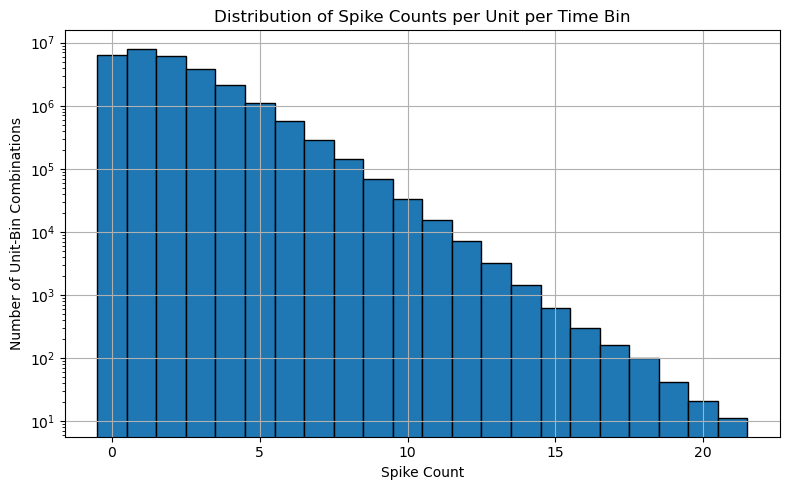

Fraction of non-zero bins: 0.7814
Fraction of non-zero examples: 1.0000


In [4]:
"""Quick plots and stats to get a sense of the spike data."""

print("Firing rates distribution:")
# Compute mean firing rate (Hz) per unit
duration_sec = len(spikes_df) * bin_size
mean_firing_rates = spikes_df.sum(axis=0) / duration_sec  # spikes_arr/sec
# Plot histogram
plt.figure(figsize=(8, 4))
plt.hist(mean_firing_rates, bins=30, edgecolor='black')
plt.xlabel('Mean Firing Rate (Hz)')
plt.ylabel('Number of Units')
plt.title('Distribution of Mean Firing Rates per Unit')
plt.grid(True)
plt.tight_layout()
plt.show()
# Print stats
print("Mean: {:.2f} Hz".format(mean_firing_rates.mean()))
print("Range: {:.2f}–{:.2f} Hz".format(mean_firing_rates.min(), mean_firing_rates.max()))

print("\n\nSpike count distribution and sparsity stats:")
# Flatten spike counts
flattened_spike_counts = spikes_df.values.flatten()
# Define bins that align exactly to integer spike counts
max_count = flattened_spike_counts.max()
bins = np.arange(0, max_count + 2) - 0.5  # centers bins on integers
# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(flattened_spike_counts, bins=bins, edgecolor='black')
plt.title("Distribution of Spike Counts per Unit per Time Bin")
plt.xlabel("Spike Count")
plt.ylabel("Number of Unit-Bin Combinations")
plt.yscale("log")
plt.grid(True)
plt.tight_layout()
plt.show()
# Print stats
frac_nonzero_bins = (spikes_df != 0).values.sum() / spikes_df.size
frac_nonzero_examples = (spikes_df.sum(axis=1) > 0).mean()
print(f"Fraction of non-zero bins: {frac_nonzero_bins:.4f}")
print(f"Fraction of non-zero examples: {frac_nonzero_examples:.4f}")


## Load and prepare environment / behavior (meta)data

In [5]:
"""Load and bin (meta)data to match spike bins."""

# Retrieve and collate metadata (hand/eye/events) across sessions
metadata, trials_df = mc_maze.retrieve_metadata(sessions) # this can take a minute
# Bin metadata to the match the binned spikes_df
metadata_binned = mc_maze.bin_metadata(metadata, trials_df, bin_size, spikes_df.index)

print("Metadata:")
display(metadata)
print("Binned metadata:")
display(metadata_binned)

Metadata:


,acc_x,acc_y,pos_x,pos_y,vel_x,vel_y,session,pos_x_eye,pos_y_eye,event,trial_idx,maze_condition,barriers,targets,hit_position_x,hit_position_y,hit_position_angle,movement_angle,vel_magnitude,accel_magnitude
timestamp,,,,,,,,,,,,,,,,,,,,
1.250035e+09,-597.299235,-707.867556,8.049750,-62.741854,-13.333198,-11.660984,0,8.9,-5.4,NaN,0.0,1,0,1,114,91,38.598461,NaN,17.713066,926.198064
1.250035e+09,-880.303924,-1072.450646,8.036417,-62.753515,-13.930497,-12.368851,0,8.8,-6.3,NaN,0.0,1,0,1,114,91,38.598461,-138.827620,18.629204,1387.474464
1.250035e+09,-1127.477697,-1461.898513,8.021889,-62.766592,-15.093806,-13.805885,0,8.6,-6.0,NaN,0.0,1,0,1,114,91,38.598461,-138.009078,20.455450,1846.172587
1.250035e+09,-1047.817355,-1481.310598,8.006229,-62.781127,-16.185452,-15.292648,0,9.0,-6.0,NaN,0.0,1,0,1,114,91,38.598461,-137.133291,22.267330,1814.442696
1.250035e+09,-953.681890,-1453.093462,7.989518,-62.797177,-17.189440,-16.768506,0,8.9,-5.7,NaN,0.0,1,0,1,114,91,38.598461,-136.155583,24.013739,1738.099467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.250056e+09,-648.362495,-77.521470,-104.161012,-152.903113,19.255021,13.089020,0,-189.8,-76.5,NaN,1905.0,17,8,1,-115,-100,-138.990906,33.841666,23.282575,652.980477
1.250056e+09,-711.932386,-150.984816,-104.142087,-152.890066,18.580509,12.983558,0,-189.9,-76.7,NaN,1905.0,17,8,1,-115,-100,-138.990906,34.581259,22.667336,727.766540
1.250056e+09,-765.812806,-233.246954,-104.123851,-152.877146,17.831156,12.787050,0,-195.2,-77.1,NaN,1905.0,17,8,1,-115,-100,-138.990906,35.318746,21.942169,800.545686


Binned metadata:


,acc_x,acc_y,pos_x,pos_y,vel_x,vel_y,session,pos_x_eye,pos_y_eye,maze_condition,barriers,targets,hit_position_x,hit_position_y,hit_position_angle,movement_angle,vel_magnitude,accel_magnitude,event,trial_idx
timestamp,,,,,,,,,,,,,,,,,,,,
1.250035e+09,-597.299235,-707.867556,8.049750,-62.741854,-13.333198,-11.660984,0,8.9,-5.4,1,0,1,114,91,38.598461,NaN,17.713066,926.198064,start,0.0
1.250035e+09,724.633463,-71.462698,7.655547,-63.249608,-16.815844,-32.225624,0,8.7,-3.9,1,0,1,114,91,38.598461,-118.063401,36.349188,728.148730,NaN,0.0
1.250035e+09,613.795526,780.186457,7.105081,-64.290522,-2.472065,-3.925894,0,9.6,-5.3,1,0,1,114,91,38.598461,-122.293361,4.639370,992.691218,NaN,0.0
1.250035e+09,167.655239,-687.202806,7.087093,-64.293778,0.387421,-3.790765,0,10.9,-5.9,1,0,1,114,91,38.598461,-84.537078,3.810511,707.358449,NaN,0.0
1.250035e+09,637.710701,-271.089828,7.157022,-64.552845,7.045371,0.681572,0,9.4,-4.5,1,0,1,114,91,38.598461,6.609140,7.078262,692.939126,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.250056e+09,-378.085848,-136.734223,-104.089753,-152.852112,16.670798,12.380330,0,-195.3,-77.3,17,8,1,-115,-100,-138.990906,36.598899,20.765069,402.051186,move_ends -> end,1905.0
1.250056e+09,-378.085848,-136.734223,-104.089753,-152.852112,16.670798,12.380330,0,-195.3,-77.3,17,8,1,-115,-100,-138.990906,36.598899,20.765069,402.051186,move_ends -> end,1905.0
1.250056e+09,-378.085848,-136.734223,-104.089753,-152.852112,16.670798,12.380330,0,-195.3,-77.3,17,8,1,-115,-100,-138.990906,36.598899,20.765069,402.051186,move_ends -> end,1905.0


## Train/val split

In [6]:
"""Train/val split, smooth and normalize spikes."""

split_by_session = False # if False, will split by proportion

if split_by_session:
    train_trials, val_trials = train_val_split_by_session(
        metadata_binned["trial_idx"].to_numpy(),
        metadata_binned["session"].to_numpy(),
        train_sessions=[1, 2],  # pick your training sessions
        shuffle=True,
        seed=0,
    )
else:
    train_trials, val_trials = train_val_split_by_proportion(
        metadata_binned["trial_idx"].values,
        train_proportion=0.8,
        shuffle=True,
        seed=0,
    )

# Create boolean masks to split metadata and spikes into train/val sets
train_mask = metadata_binned['trial_idx'].isin(train_trials)
val_mask = metadata_binned['trial_idx'].isin(val_trials)

# Split metadata
metadata_binned_train = metadata_binned[train_mask].reset_index(drop=True)
metadata_binned_val = metadata_binned[val_mask].reset_index(drop=True)

# Split spikes 
spikes_arr = spikes_df.values.astype(np.float32)
spikes_train_arr = spikes_arr[train_mask]
spikes_val_arr = spikes_arr[val_mask]

# Smooth spikes
sigma = 0.05 / bin_size
spikes_train_arr = gaussian_filter1d(spikes_train_arr, sigma=sigma, axis=0)
spikes_val_arr = gaussian_filter1d(spikes_val_arr, sigma=sigma, axis=0)

# Normalize spikes (fit normalization on training data only)
train_max = spikes_train_arr.max()
spikes_train_arr = spikes_train_arr / train_max
spikes_val_arr = spikes_val_arr / train_max

# Summary
print(f"Train set: {len(train_trials)} trials ({train_mask.sum()} time bins)")
print(f"Val set: {len(val_trials)} trials ({val_mask.sum()} time bins)")
print(f"Spike data shapes: train {spikes_train_arr.shape}, val {spikes_val_arr.shape}")

Train set: 1524 trials (120064 time bins)
Val set: 382 trials (30421 time bins)
Spike data shapes: train (120064, 191), val (30421, 191)


In [7]:
"""Convert spike data to torch tensors and move to torch device."""

# it's best to have a gpu for training!
device = t.device("cuda" if t.cuda.is_available() else "cpu")
print(f"{device=}")

spikes_train = t.from_numpy(spikes_train_arr).to(device).to(dtype=t.bfloat16)
spikes_val = t.from_numpy(spikes_val_arr).to(device).to(dtype=t.bfloat16)

display(spikes_train)
display(spikes_val)

device=device(type='cuda')


tensor([[0.1050, 0.0913, 0.0233,  ..., 0.0693, 0.0654, 0.0098],
        [0.1201, 0.1206, 0.0535,  ..., 0.1040, 0.0933, 0.0405],
        [0.0830, 0.1738, 0.0845,  ..., 0.0854, 0.1118, 0.0669],
        ...,
        [0.0000, 0.0625, 0.1260,  ..., 0.0167, 0.0479, 0.0693],
        [0.0000, 0.0615, 0.1133,  ..., 0.0033, 0.0272, 0.0425],
        [0.0000, 0.0364, 0.0698,  ..., 0.0003, 0.0065, 0.0203]],
       device='cuda:0', dtype=torch.bfloat16)

tensor([[0.0000e+00, 1.3086e-01, 2.0264e-02,  ..., 7.1777e-02, 4.2969e-02,
         4.5654e-02],
        [7.4506e-06, 1.4453e-01, 4.2236e-02,  ..., 3.6621e-02, 8.9355e-02,
         6.0547e-02],
        [2.5368e-04, 1.2988e-01, 6.5918e-02,  ..., 2.9785e-02, 1.1670e-01,
         8.9844e-02],
        ...,
        [0.0000e+00, 6.2561e-03, 3.3936e-02,  ..., 2.2949e-02, 8.9355e-02,
         1.7383e-01],
        [0.0000e+00, 1.6724e-02, 2.2705e-02,  ..., 3.6133e-02, 7.1777e-02,
         1.1768e-01],
        [0.0000e+00, 3.5645e-02, 3.6133e-02,  ..., 7.1777e-02, 5.9082e-02,
         7.9590e-02]], device='cuda:0', dtype=torch.bfloat16)

# 2. Train models

> If desired, you can choose to skip this section and load pre-saved SAE unit activations instead. A set of activations per subject (Jenkins and Nitschke) is provided - go to section "3. Save/load SAE activations" for more information. It is however still highly recommended to read the rest of this section to understand how the SAEs are trained.

This code trains 2 SAEs with identical setups so that you can compare the different instances and ensure they both give similar results. For each time bin of neural data in the train and val sets, the SAEs' hidden-layer unit activations are calculated, and it is these activations that will be used to find a unit's correspondence with external variables (features). A particularity of the NLDisco pipeline below is that it trains *Matryoshka* SAEs.

**Matryoshka architecture:**

The Matryoshka architecture segments the latent space into multiple levels, each of which attempts a full reconstruction of the target neural activity. In the figure below, black boxes indicate the latents (model neurons) involved in a given level, while light-red boxes indicate additional latents recruited at lower levels. A top-$k$ selection is used to choose which latents to recruit for reconstruction at each level (yellow neuron within each light-red box -- $k=1$ for each level in this example).

This nested arrangement is motivated by the idea that multi-scale feature learning can mitigate “feature absorption” (a common issue where a more specific feature subsumes a portion of a more general feature), allowing both coarse and detailed representations to emerge simultaneously.

- Latents in the highest level ($L_1$) typically correspond to broad, high-level features (e.g., a round object), 
- Latents exclusive to the lowest level ($L_3$) often correspond to more specific, fine-grained features (e.g., a basketball)

![](./tutorial_figures/msae.svg)

**Key training parameters to play with:**

`SedConfig` (model-level):
- `dsed_topk_map`: how many top-k units are kept active at each level (controls sparsity per level)
- `dsed_loss_x_map`: relative weight of each Matryoshka level to the overall reconstruction loss

`optimize()` (optimizer-level):
- `n_steps`: total training steps
- `batch_sz`: how many examples per batch
- `lr` (set in optimizer): learning rate used by whatever optimizer you choose (e.g. Adam below) and you can optionally use a scheduler (`use_lr_sched=True`)
- `dead_latent_window`: number of steps a latent (model neuron) can stay inactive before being flagged as “dead”  
  - Dead latents are revived with an auxiliary loss: instead of reconstructing the full input, they try to reconstruct only the residual error (the part the active units failed to capture)
  - This gives inactive latents a chance to become useful again, preventing them from staying permanently silent   
- `loss_fn` – reconstruction objective: built-ins are mse and msle, or you can pass a custom callable


## Train SAEs

In [8]:
"""Set config."""

# total of 1024 model neurons in 3 nested levels: 0-256, 0-512 and 0-1024
dsae_topk_map = {256: 8, 512: 16, 1024: 24}
dsae_topk_map = dict(sorted(dsae_topk_map.items()))  # ensure sorted from smallest to largest
dsae_loss_x_map = {256: 1, 512: 1.25, 1024: 1.5}
dsae_loss_x_map = dict(sorted(dsae_loss_x_map.items()))
dsae = max(dsae_topk_map.keys())
n_inst = 2  # number of SAE instances to train in parallel

In [9]:
"""Train model."""

sae_cfg = nt.SedConfig(
    n_input=spikes_train.shape[1],
    dsed_topk_map=dsae_topk_map,
    dsed_loss_x_map=dsae_loss_x_map,
    n_instances=n_inst,
)
sae = nt.Sed(sae_cfg).to(device)
loss_fn = nt.msle
lr = 5e-3

n_epochs = 20
batch_sz = 1024
n_steps = (spikes_train.shape[0] // batch_sz) * n_epochs
log_freq = max(1, n_steps // n_epochs // 2)
dead_latent_window = max(1, n_steps // n_epochs // 3)

data_log = nt.optimize(  # train model
    spk_cts=spikes_train,
    sed=sae,
    loss_fn=loss_fn,
    optimizer=t.optim.Adam(sae.parameters(), lr=lr),
    use_lr_sched=True,
    dead_latent_window=dead_latent_window,
    n_steps=n_steps,
    log_freq=log_freq,
    batch_sz=batch_sz,
    log_wandb=False,
    plot_l0=False,
)

sed batch training step: 100%|██████████| 2340/2340 [00:19<00:00, 117.02it/s, loss=0.00409,  l0_mean=24.0, l0_std=5.92791748046875, frac_dead=0.93603515625]  


## Validate SAEs

In [10]:
"""Check for nans in weights."""

sae.W_dec.isnan().sum(), sae.W_enc.isnan().sum()

(tensor(0, device='cuda:0'), tensor(0, device='cuda:0'))

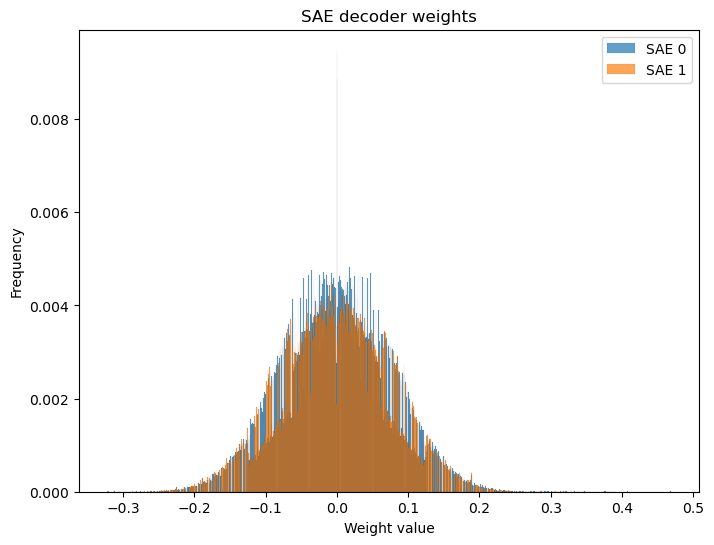

In [11]:
"""Visualize weights."""

fig, ax = plt.subplots(figsize=(8, 6))
for inst in range(n_inst):
    W_dec_flat = asnumpy(sae.W_dec[inst].float()).ravel()
    sns.histplot(W_dec_flat, bins=1000, stat="probability", alpha=0.7, label=f"SAE {inst}")
    
ax.set_title("SAE decoder weights")
ax.set_xlabel("Weight value")
ax.set_ylabel("Frequency")
ax.legend()

SED batch evaluation step: 100%|██████████| 117/117 [00:00<00:00, 523.56it/s]
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/nfs/nhome/live/jbhagat/mini/src/nldisco/train.py:469: UserWar

(0.0, 0.025)

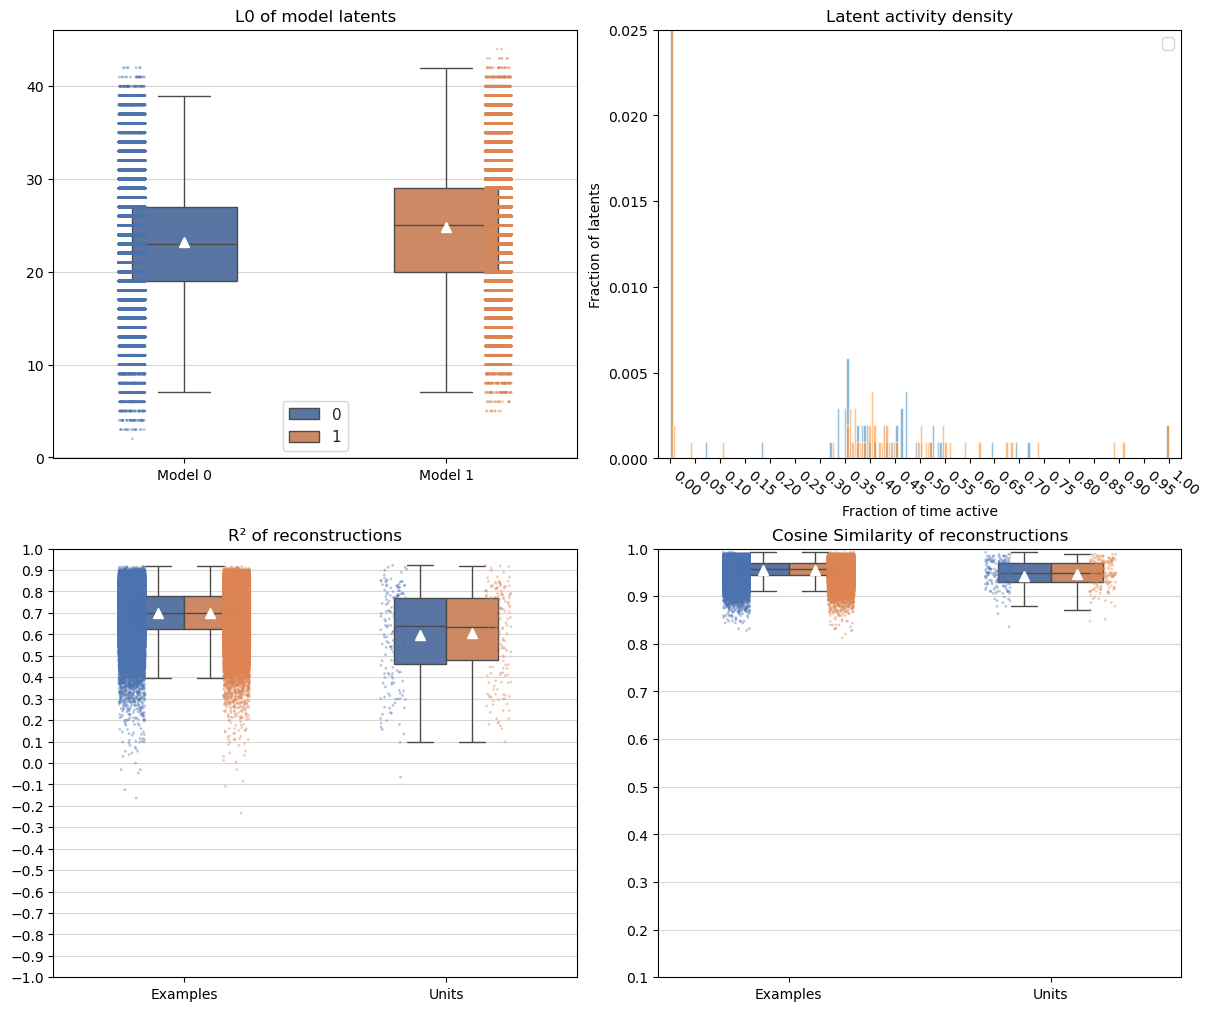

In [12]:
"""Visualize metrics over all examples and units."""

fig, topk_acts_4d_train, recon_spk_cts_train, r2_per_unit_train, _, cossim_per_unit_train, _ = (
    nt.eval_model(spikes_train, sae, batch_sz=batch_sz)
)

In [13]:
"""Calculate variance explained of summed spike counts."""

n_recon_examples = recon_spk_cts_train.shape[0]
recon_summed_spk_cts = reduce(recon_spk_cts_train, "example inst neuron -> example inst", "sum")

actual_summed_spk_cts = reduce(spikes_train, "example neuron -> example", "sum")
actual_summed_spk_cts = actual_summed_spk_cts[:n_recon_examples]  # trim to match

for inst in range(n_inst):
    r2 = r2_score(
        asnumpy(actual_summed_spk_cts.float()),
        asnumpy(recon_summed_spk_cts[:, inst].float()),
    )
    print(f"SAE instance {inst} R² (summed spike count over all neurons per example) = {r2:.3f}")


SAE instance 0 R² (summed spike count over all neurons per example) = 0.997
SAE instance 1 R² (summed spike count over all neurons per example) = 0.998


## Remove bad units and retrain

In [14]:
"""Remove bad uints and retrain."""

# Set threshold for removing units
r2_thresh = 0.1
inst = 0
r2_inst = r2_per_unit_train[:, inst]
keep_mask = r2_inst > r2_thresh
print(f"frac units above {r2_thresh=}: {keep_mask.sum() / keep_mask.shape[0]:.2f}")
print(f"Number to keep: {keep_mask.sum()} / {keep_mask.shape[0]}")

if keep_mask.all():
    print("All units pass threshold — skipping retrain.")
    spikes_train_pruned = spikes_train
    spikes_val_pruned = spikes_val
else:
    # Prune
    spikes_train_pruned = spikes_train[:, keep_mask]
    spikes_val_pruned = spikes_val[:, keep_mask]

    # Retrain SAE on pruned train data
    sae_cfg = nt.SedConfig(
        n_input=spikes_train_pruned.shape[1],
        dsed_topk_map=dsae_topk_map,
        dsed_loss_x_map=dsae_loss_x_map,
        seq_len=1,
        n_instances=n_inst,
    )
    sae = nt.Sed(sae_cfg).to(device)
    loss_fn = nt.msle
    lr = 5e-3

    n_epochs = 20
    batch_sz = 1024
    n_steps = (spikes_train_pruned.shape[0] // batch_sz) * n_epochs
    log_freq = max(1, n_steps // n_epochs // 2)
    dead_latent_window = max(1, n_steps // n_epochs // 3)

    data_log = nt.optimize(
        spk_cts=spikes_train_pruned,
        sed=sae,
        loss_fn=loss_fn,
        optimizer=t.optim.Adam(sae.parameters(), lr=lr),
        use_lr_sched=True,
        dead_latent_window=dead_latent_window,
        n_steps=n_steps,
        log_freq=log_freq,
        batch_sz=batch_sz,
        log_wandb=False,
        plot_l0=False,
    )

frac units above r2_thresh=0.1: 0.99
Number to keep: 189 / 191


sed batch training step: 100%|██████████| 2340/2340 [00:22<00:00, 102.62it/s, loss=0.00416,  l0_mean=24.0, l0_std=6.257618427276611, frac_dead=0.931640625]  


SED batch evaluation step: 100%|██████████| 117/117 [00:00<00:00, 541.96it/s]
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/nfs/nhome/live/jbhagat/mini/src/nldisco/train.py:469: UserWar

SAE instance 0 R² (summed spike count per example) = 0.998
SAE instance 1 R² (summed spike count per example) = 0.997


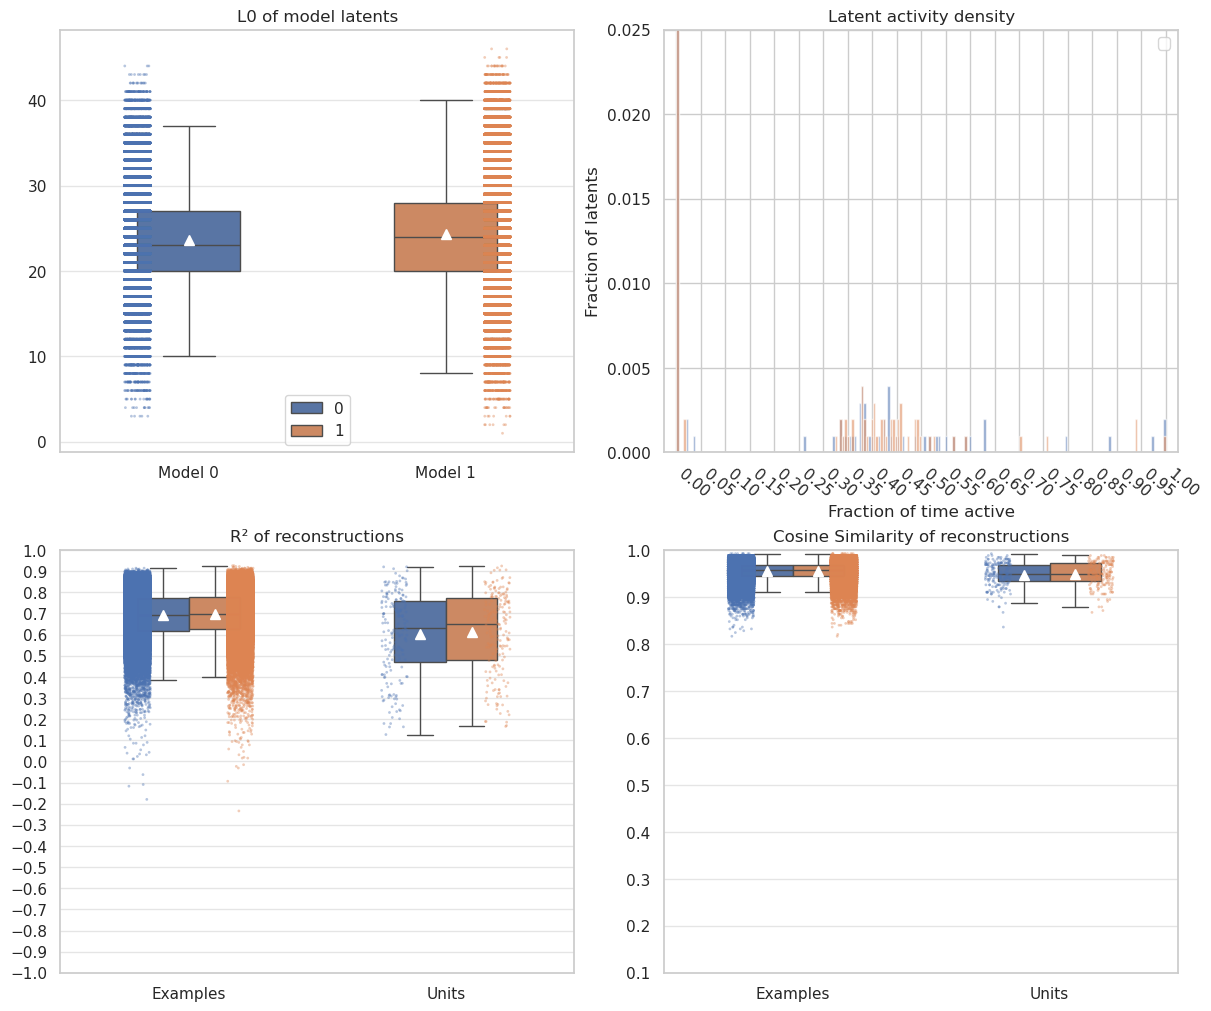

In [15]:
"""Re-visualize metrics over all examples and units."""

if keep_mask.all():
    print("All units pass threshold — skipping re-visualization.")
else:
    fig, topk_acts_4d_train, recon_spk_cts_train, r2_per_unit_train, _, cossim_per_unit_train, _ = (
        nt.eval_model(spikes_train_pruned, sae, batch_sz=batch_sz)
)
    n_recon_examples_train = recon_spk_cts_train.shape[0]
    recon_summed_train = reduce(recon_spk_cts_train, "example inst unit -> example inst", "sum")

    actual_summed_train = reduce(spikes_train_pruned, "example unit -> example", "sum")
    actual_summed_train = actual_summed_train[:n_recon_examples_train]

    for inst in range(n_inst):
        r2 = r2_score(
            asnumpy(actual_summed_train.float()),
            asnumpy(recon_summed_train[:, inst].float()),
        )
        print(f"SAE instance {inst} R² (summed spike count per example) = {r2:.3f}")

Validation data metrics:


SED batch evaluation step: 100%|██████████| 29/29 [00:00<00:00, 576.80it/s]
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/nfs/nhome/live/jbhagat/mini/src/nldisco/train.py:469: UserWarni

SAE instance 0 R² (summed spike count per example) = 0.998
SAE instance 1 R² (summed spike count per example) = 0.997


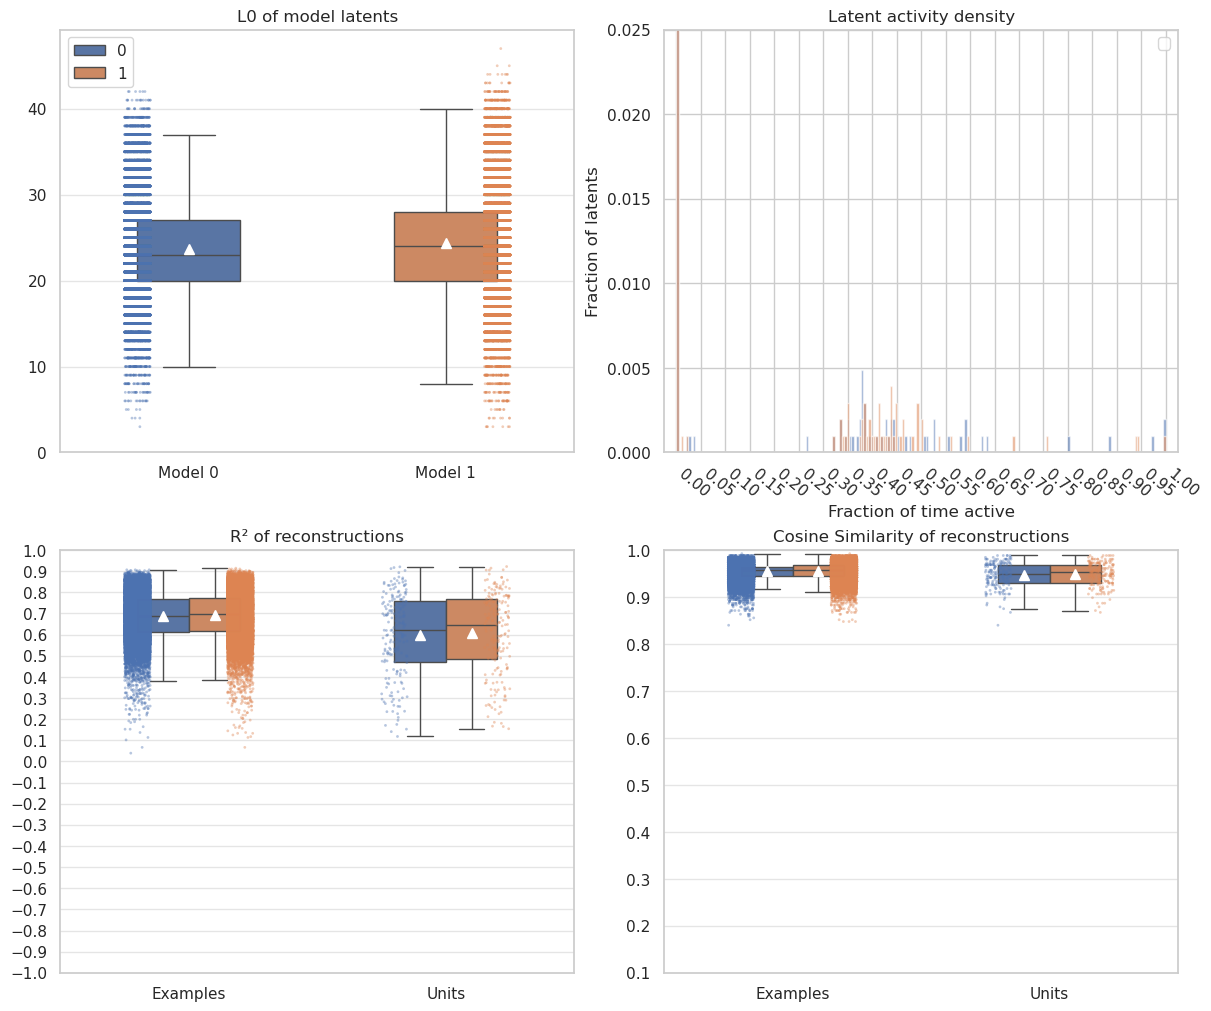

In [ ]:
"""Visualize metrics on validation data."""

if spikes_val_pruned.shape[0] == 0:
    print("No validation data available.")
else:
    print("Validation data metrics:")

    fig, topk_acts_4d_val, recon_spk_cts_val, r2_per_unit_val, _, cossim_per_unit_val, _ = (
        nt.eval_model(spikes_val_pruned, sae, batch_sz=batch_sz)
)
    n_recon_examples_val = recon_spk_cts_val.shape[0]
    recon_summed_val = reduce(recon_spk_cts_val, "example inst unit -> example inst", "sum")

    actual_summed_val = reduce(spikes_val_pruned, "example unit -> example", "sum")
    actual_summed_val = actual_summed_val[:n_recon_examples_val]

    for inst in range(n_inst):
        r2 = r2_score(
            asnumpy(actual_summed_val.float()),
            asnumpy(recon_summed_val[:, inst].float()),
        )
        print(f"SAE instance {inst} R² (summed spike count per example) = {r2:.3f}")

# 3. Save/load SAE activations

A set of activations per subject (Jenkins and Nitschke) is provided in the `saved_sae_unit_activations` folder. They were both generated using a split by proportion (80/20 train/val split). If you want to use them, set the `load_activations` variable below to `True`.

In [17]:
"""Load saved activations if available; otherwise build acts_df and (optionally) save."""

save_path = Path(r"../saved_sae_unit_activations")
load_activations = False
save_activations = True
activations_file_train = "sae_activations_train.parquet"
activations_file_val = "sae_activations_val.parquet"
mask_file_train = "train_mask.parquet"
mask_file_val = "val_mask.parquet"

# Build save path (same style as before)
session_dates = []
for session in sessions:
    session_date = datetime.fromtimestamp(session.session.recording_date).strftime("%Y%m%d")
    session_dates.append(session_date)
session_dates_str = "_".join(session_dates)

activations_save_path = save_path / f"{subject_name}_{session_dates_str}" / "sae_activations"
activations_save_path.mkdir(parents=True, exist_ok=True)

if load_activations:
    acts_df_train = pd.read_parquet(activations_save_path / activations_file_train)
    acts_df_val = (
        pd.read_parquet(activations_save_path / activations_file_val) 
        if (activations_save_path / activations_file_val).exists() else None
    )
    train_mask = pd.read_parquet(activations_save_path / mask_file_train)["mask"]
    val_mask = pd.read_parquet(activations_save_path / mask_file_val)["mask"]
    print(f"Loaded activations from {activations_save_path}")
else:
    # Train
    arr_tr = asnumpy(topk_acts_4d_train)  # [example_idx, instance_idx, latent_idx, act_value]
    # Sparse activations (tight dtypes on indices, fp32 values)
    acts_df_train = pd.DataFrame({
        "example_idx": arr_tr[:, 0].astype(int),
        "instance_idx": arr_tr[:, 1].astype(int),
        "latent_idx": arr_tr[:, 2].astype(int),
        "activation_value": arr_tr[:, 3].astype(np.float32),
    })

    if spikes_val_pruned.shape[0] > 0:
        # Val
        arr_va = asnumpy(topk_acts_4d_val)
        acts_df_val = pd.DataFrame({
            "example_idx": arr_va[:, 0].astype(int),
            "instance_idx": arr_va[:, 1].astype(int),
            "latent_idx": arr_va[:, 2].astype(int),
            "activation_value": arr_va[:, 3].astype(np.float32),
        })
    else:
        acts_df_val = None

    n_examples_train = (int(acts_df_train["example_idx"].max()) + 1)
    std_threshold = 1e-6

    # Precompute squared values once, then sum both in one grouped pass
    acts_df_train_with_sq = (
        acts_df_train.assign(activation_value_sq=acts_df_train["activation_value"] ** 2)
    )

    unit_stats = (
        acts_df_train_with_sq.groupby(["instance_idx", "latent_idx"], as_index=False)
          .agg(sum_val=("activation_value", "sum"),
               sum_sq=("activation_value_sq", "sum"))
    )
    # Population variance which takes into account missing rows where activations are zero
    unit_stats["mean"] = unit_stats["sum_val"] / n_examples_train
    unit_stats["var"]  = (unit_stats["sum_sq"] / n_examples_train) - unit_stats["mean"]**2
    unit_stats["std"]  = np.sqrt(np.clip(unit_stats["var"].to_numpy(), 0.0, None))

    kept_unit = unit_stats.loc[unit_stats["std"] > std_threshold, ["instance_idx", "latent_idx"]]
    n_dropped = len(unit_stats) - len(kept_unit)

    if n_dropped:
        # Semi-join to keep only surviving (instance, unit) pairs
        acts_df_train = acts_df_train.merge(
            kept_unit, on=["instance_idx", "latent_idx"], how="inner"
        )
        acts_df_val = (
            acts_df_val.merge(kept_unit, on=["instance_idx", "latent_idx"], how="inner") 
            if (spikes_val_pruned.shape[0] > 0) else None
        )
        print(f"Pruned {n_dropped} units (std ≤ {std_threshold}). Kept {len(kept_unit)}.")

    if save_activations:
        acts_df_train.to_parquet(activations_save_path / activations_file_train, index=False)
        (
            acts_df_val.to_parquet(activations_save_path / activations_file_val, index=False) 
            if spikes_val_pruned.shape[0] > 0 else None
        )
        train_mask.to_frame(name="mask").to_parquet(
            activations_save_path / mask_file_train, index=True
        )
        val_mask.to_frame(name="mask").to_parquet(
            activations_save_path / mask_file_val, index=True
        )
        print(f"Saved activations to {activations_save_path}")

if acts_df_val is not None:
    print(f"Activations: \nTrain shape: {acts_df_train.shape}, Val shape: {acts_df_val.shape}")
else:
    print(f"Activations: \nTrain shape: {acts_df_train.shape}")

Saved activations to ../saved_sae_unit_activations/nitschke_20090812/sae_activations
Activations: 
Train shape: (5750784, 4), Val shape: (1425408, 4)


# 4. Find features

## Pick dataset

In [18]:
"""Pick whether to find features in training or validation set."""

search_train = True

if search_train:
    acts_df_split = acts_df_train
    metadata_binned_split = metadata_binned[train_mask].copy()
    spikes_df_split = spikes_df[train_mask].copy()
else:
    acts_df_split = acts_df_val
    metadata_binned_split = metadata_binned[val_mask].copy()
    spikes_df_split = spikes_df[val_mask].copy()

## Automatically map latents to metadata

Now we see if latents represent properties of known continuous and discrete behavioral and environmental variables in the MC_Maze task.

**How it works:**

Latents are mapped to real-world variables through the calculation of a selectivity score. For a latent $l$ and condition $c$ (variable/value combination e.g., velocity is between 0 and 1, or maze condition = 3, etc.):

$$
\text{activation\_frac\_during} =
\frac{\#\{\text{activations of } l \text{ in examples with } c\}}
     {\#\{\text{examples with } c\}}
$$

$$
\text{activation\_frac\_outside} =
\frac{\#\{\text{activations of } l \text{ in examples without } c\}}
     {\#\{\text{examples without } c\}}
$$

$$
\text{selectivity\_score} =
\frac{\text{activation\_frac\_during}}
     {\text{activation\_frac\_during} + \text{activation\_frac\_outside}}
$$

- $\approx 1$: unit mainly active *during* the condition (highly selective)  
- $\approx 0.5$: unit active equally in/out (not selective)  
- $\approx 0$: unit mostly active *outside* the condition

The `map_latents_to_metadata` function:
1. For discrete variables: computes activation fractions + selectivity score per condition value.  
2. For continuous variables: bins, then reuses discrete analysis.  
3. Results are ranked by selectivity score and the `top_n_mappings` are returned.

**Key arguments to play with:**
- `discrete_vars` and `continuous_vars`: as default only one of each was included because the function takes time to run, but you may be interested in exploring different or additional variables
- `n_bins_continuous`: number of bins for continuous variables. This will affect whether you find more general features (small number of bins so you have less granularity e.g., you can only distinguish between fast vs slow hand velocity) or specific features (larger number of bins for more granularity e.g., you can now distinguish between very fast vs fast vs intermediate vs slow vs very slow hand velocity)
- `min_activation_frac`: minimum fraction of condition examples a unit must activate in
- `top_n_mappings`: number of highest-scoring mappings kept per variable/value/instance combination (default `3`)

In [ ]:
"""Map units to metadata variables."""

# discrete_vars = ['event', 'maze_condition', 'barriers', 'targets', 'hit_position_x', 'hit_position_y', 'hit_position_angle']
# continuous_vars = ['vel_magnitude', 'accel_magnitude', 'movement_angle']
discrete_vars = ['event']
continuous_vars = ['vel_magnitude']
latent_metadata_mapping = pipeline.map_latents_to_metadata(  # this can take a minute
    acts_df_split,
    metadata_binned_split,
    discrete_vars=discrete_vars,
    continuous_vars=continuous_vars,
    min_activation_frac=0.5,
    n_bins_continuous=[12],
    top_n_mappings=5
)
latent_metadata_mapping

Starting automated unit-to-metadata mapping...

Analyzing variable: event...
    Found 263 potential associations

Analyzing variable: vel_magnitude...
    Binning 'vel_magnitude' into 12 bins...
    Found 330 potential associations

Selecting top 5 mappings for each variable/value/instance combination...

Found 110 top discrete associations
Found 120 top continuous associations
Total: 230 associations returned in single DataFrame


,variable,variable_type,value,instance_idx,latent_idx,activation_frac_during,activation_frac_outside,selectivity_score
0,vel_magnitude,continuous,"(0.00568, 0.993]",0.0,59.0,0.594743,0.358111,0.624170
1,vel_magnitude,continuous,"(0.00568, 0.993]",0.0,87.0,0.987907,0.598303,0.622810
2,vel_magnitude,continuous,"(0.00568, 0.993]",0.0,30.0,0.635419,0.559078,0.531955
3,vel_magnitude,continuous,"(0.00568, 0.993]",0.0,607.0,0.667899,0.625243,0.516493
4,vel_magnitude,continuous,"(0.00568, 0.993]",0.0,98.0,0.540476,0.512484,0.513292
...,...,...,...,...,...,...,...,...
225,event,discrete,target_on -> go_cue,1.0,166.0,0.661108,0.581894,0.531864
226,event,discrete,target_on -> go_cue,1.0,159.0,0.542970,0.478412,0.531604
227,event,discrete,target_on -> go_cue,1.0,116.0,0.553785,0.491501,0.529793
228,event,discrete,target_on -> go_cue,1.0,123.0,0.516965,0.466156,0.525841


## Find meaningful features and their contributing units

The code below generates a dashboard like this one, providing an interactive way to explore a model's latents in search for meaningful features and their contributing units:

![](./tutorial_figures/feature_finding_dashboard.png)

The `latent_metadata_mapping` dataframe generated is used as a starting point to identify promising features ("preset" option on the dashboard). If you want more preset options to explore, feel free to return to the "Automatically map latents to metadata" section and play with the arguments that control the mapping process.

You may also choose to look through latents manually, though this tends to take more time ("manual selection" option on the dashboard).

Remember:
- Matryoshka SAEs split latents across multiple levels, with higher levels capturing broad patterns and lower levels capturing more specific ones. Check the `dsae` settings you used to train your SAEs to see what latents were allocated to each level.
- The neural recordings come from two brain regions (PMd and M1). Use the `neurons_df` dataframe generated below to look up the mapping of neuron IDs to brain regions - this can help you see whether particular features are driven more strongly by neurons in one region or the other.
- By default, this tutorial set `search_train = True` at the beginning of this section, so the feature search runs on the training set. You can switch to the validation set instead, which lets you check that the SAEs generalise to unseen data (and to unseen sessions if you chose to split by session in section "1. Load and prepare data").

*Note*: Here we present a prepared dashboard for viewing the activity of latents in the context of the MC_Maze task. In general when working with new datasets, we recommend spending some time designing similar simple, bespoke dashboards.

In [21]:
"""Print neuron to brain region mapping for reference."""

neuron_ids = [u.decode() for u in session.units.id]
neurons_df = pd.DataFrame({
    "neuron_id": [int(u.split("elec")[1]) for u in neuron_ids],
    "region": ["PMd" if "group_1" in u else "M1" for u in neuron_ids]
})

neurons_df

,neuron_id,region
0,0,PMd
1,2,PMd
2,3,PMd
3,4,PMd
4,5,PMd
...,...,...
186,187,M1
187,188,M1
188,189,M1
189,190,M1


In [ ]:
"""Feature finding dashboard."""

pipeline.build_feature_finding_dashboard(
    unit_metadata_mapping=latent_metadata_mapping,
    acts_df=acts_df_split,
    spikes_df=spikes_df_split,
    metadata_binned=metadata_binned_split
)